In [1]:
import mysql.connector
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# CONNECT TO MYSQL (same server as MySQL Workbench)
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="BlueSky!88",
    port=3306,
    database="banking_fraud_detection"
)




In [ ]:
# LOAD DATA FROM SQL
query = """
SELECT
    t.transaction_id,
    t.account_id,
    t.txn_timestamp,
    t.amount,
    t.txn_type,
    t.channel,
    t.is_international,
    t.label_fraud,
    a.account_type,
    a.balance,
    c.customer_id,
    c.gender,
    c.city,
    c.state,
    c.dob
FROM transactions t
JOIN accounts a   ON t.account_id = a.account_id
JOIN customers c  ON a.customer_id = c.customer_id;
"""

df = pd.read_sql(query, conn)
conn.close()

print("Data loaded from MySQL. Shape:", df.shape)
print(df.head())


Data loaded from MySQL. Shape: (559, 15)
   transaction_id  account_id       txn_timestamp  amount txn_type channel  \
0               1         101 2023-06-01 09:00:00  1250.0      POS    card   
1               2         102 2023-06-01 09:40:00  2000.0      UPI  mobile   
2               3         201 2023-06-01 10:20:00  2750.0   ONLINE  online   
3               4         202 2023-06-01 11:00:00  3500.0      ATM     atm   
4               5         301 2023-06-01 11:40:00  4250.0     NEFT  online   

  is_international  label_fraud account_type   balance  customer_id gender  \
0                N            0      savings   50000.0            1      M   
1                N            0      current  120000.0            1      M   
2                N            0      savings   80000.0            2      F   
3                N            0       salary   45000.0            2      F   
4                N            0      savings   60000.0            3      M   

        city        s

C:\Users\ksrsu\AppData\Local\Temp\ipykernel_3328\3119563596.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
# BASIC CLEANING & FEATURE ENGINEERING

df["txn_timestamp"] = pd.to_datetime(df["txn_timestamp"])


df["hour"] = df["txn_timestamp"].dt.hour
df["day_of_week"] = df["txn_timestamp"].dt.weekday
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)


df["dob"] = pd.to_datetime(df["dob"])
df["age"] = (df["txn_timestamp"].dt.year - df["dob"].dt.year).clip(lower=18, upper=90)


df["is_international_flag"] = df["is_international"].map({"Y": 1, "N": 0})

df["txns_per_account"] = df.groupby("account_id")["transaction_id"].transform("count")
df["avg_amount_account"] = df.groupby("account_id")["amount"].transform("mean")


df["avg_amount_account"] = df["avg_amount_account"].fillna(df["avg_amount_account"].median())
df["balance"] = df["balance"].fillna(df["balance"].median())

print("\n Feature engineering done.")
print(df[["amount","txn_type","channel","is_international_flag","hour","day_of_week","age","txns_per_account"]].head())


 Feature engineering done.
   amount txn_type channel  is_international_flag  hour  day_of_week  age  \
0  1250.0      POS    card                      0     9            3   28   
1  2000.0      UPI  mobile                      0     9            3   28   
2  2750.0   ONLINE  online                      0    10            3   25   
3  3500.0      ATM     atm                      0    11            3   25   
4  4250.0     NEFT  online                      0    11            3   31   

   txns_per_account  
0                37  
1                37  
2                37  
3                37  
4                36  


In [5]:
# 4. DEFINE FEATURES (X) AND TARGET (y)


target_col = "label_fraud"
y = df[target_col]

# Numerical features
numeric_features = [
    "amount",
    "balance",
    "hour",
    "day_of_week",
    "is_weekend",
    "is_international_flag",
    "age",
    "txns_per_account",
    "avg_amount_account"
]

# Categorical features
categorical_features = [
    "txn_type",
    "channel",
    "account_type",
    "gender",
    "city",
    "state"
]

feature_cols = numeric_features + categorical_features
X = df[feature_cols]


In [6]:
# 5. PREPROCESSOR (One-Hot for categoricals)


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

In [7]:
# 6. TRAIN-TEST SPLIT


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y  
)

print("\n Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Fraud in full data:", y.sum(), "/", len(y))




 Train size: (391, 15) | Test size: (168, 15)
Fraud in full data: 60 / 559


In [ ]:
# 7. BUILD PIPELINE: PREPROCESSOR + SMOTE + RANDOM FOREST


rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  
)

clf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", rf_model)
])

In [10]:
# 8. TRAIN MODEL


print("\n Training model...")
clf.fit(X_train, y_train)
print(" Training complete.")


 Training model...
 Training complete.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# 1) Get fraud probabilities once
fraud_probs = clf.predict_proba(X_test)[:, 1]

# 2) Try different thresholds
thresholds = [0.50, 0.40, 0.30, 0.25, 0.20]

for threshold in thresholds:
    print("=" * 60)
    print(f" Threshold = {threshold}")

    # 3) Convert probs → class labels using this threshold
    y_pred = (fraud_probs >= threshold).astype(int)

    # 4) Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f" Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()  # blank line


🔹 Threshold = 0.5
 Accuracy: 0.9524

Classification Report:
              precision    recall  f1-score   support

           0     0.9494    1.0000    0.9740       150
           1     1.0000    0.5556    0.7143        18

    accuracy                         0.9524       168
   macro avg     0.9747    0.7778    0.8442       168
weighted avg     0.9548    0.9524    0.9462       168

Confusion Matrix:
[[150   0]
 [  8  10]]

🔹 Threshold = 0.4
 Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

           0     0.9615    1.0000    0.9804       150
           1     1.0000    0.6667    0.8000        18

    accuracy                         0.9643       168
   macro avg     0.9808    0.8333    0.8902       168
weighted avg     0.9657    0.9643    0.9611       168

Confusion Matrix:
[[150   0]
 [  6  12]]

🔹 Threshold = 0.3
 Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

           0     0.9615    

In [ ]:
# 10. FRAUD PROBABILITY FOR SAMPLE TRANSACTIONS

print("\n Fraud probability for last 10 transactions in dataset:")

X_last10 = X.tail(10)
probs = clf.predict_proba(X_last10)[:, 1]  # probability of class 1 (fraud)

result_preview = df[["transaction_id","amount","txn_type","channel","is_international","account_type"]].tail(10).copy()
result_preview["fraud_prob"] = np.round(probs, 4)
print(result_preview)




🔍 Fraud probability for last 10 transactions in dataset:
     transaction_id    amount txn_type channel is_international account_type  \
549             551   13200.0   ONLINE  online                N  credit_card   
550             552  175000.0     NEFT  online                N         loan   
551             553    5200.0      UPI  mobile                N       salary   
552             554   88000.0     NEFT  online                N      current   
553             555   36000.0   ONLINE  online                N  credit_card   
554             556  220000.0     NEFT  online                N         loan   
555             557    4500.0      UPI  mobile                N       salary   
556             558   99000.0     NEFT  online                Y      current   
557             559   30000.0      POS    card                N  credit_card   
558             560  250000.0     NEFT  online                N         loan   

     fraud_prob  
549      0.0478  
550      0.1624  
551    

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)


In [14]:
fraud_probs = clf.predict_proba(X_test)[:, 1]   # P(fraud=1)


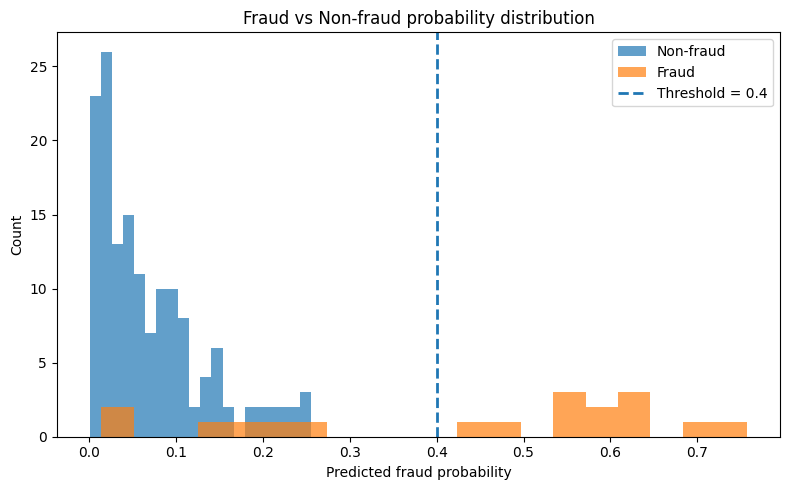

In [15]:
FINAL_THRESHOLD = 0.40   # or whatever you decide

plt.figure(figsize=(8, 5))

plt.hist(fraud_probs[y_test == 0], bins=20, alpha=0.7, label="Non-fraud")
plt.hist(fraud_probs[y_test == 1], bins=20, alpha=0.7, label="Fraud")

plt.axvline(FINAL_THRESHOLD, linestyle="--", linewidth=2, label=f"Threshold = {FINAL_THRESHOLD}")

plt.xlabel("Predicted fraud probability")
plt.ylabel("Count")
plt.title("Fraud vs Non-fraud probability distribution")
plt.legend()
plt.tight_layout()
plt.show()


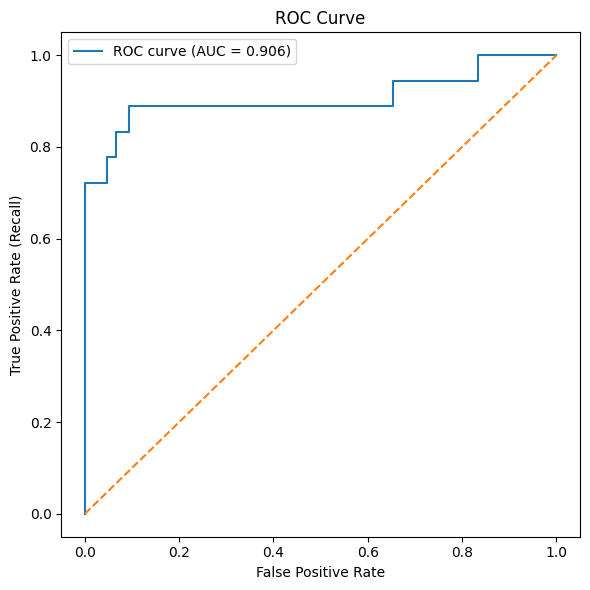

In [16]:
fpr, tpr, roc_thr = roc_curve(y_test, fraud_probs)
roc_auc = roc_auc_score(y_test, fraud_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


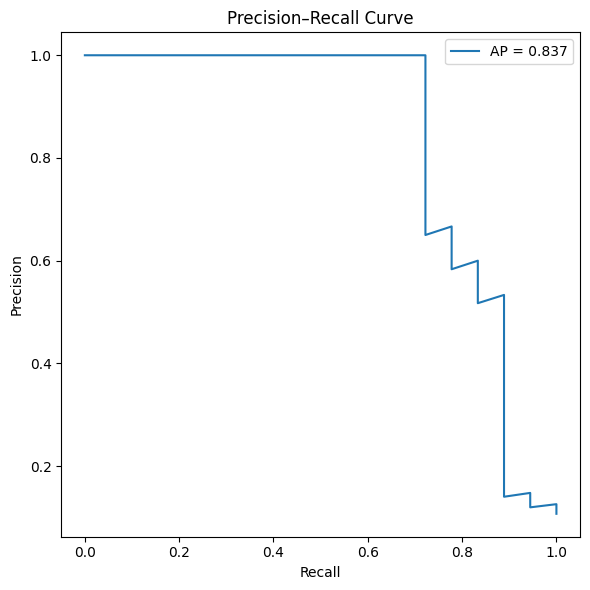

In [17]:
precision, recall, pr_thr = precision_recall_curve(y_test, fraud_probs)
avg_prec = average_precision_score(y_test, fraud_probs)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"AP = {avg_prec:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


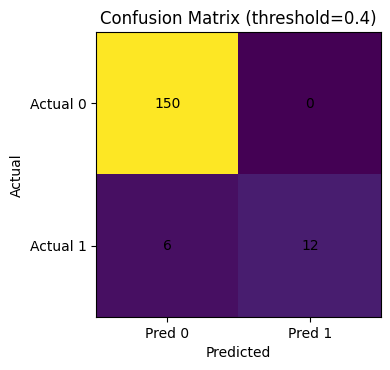

In [18]:
FINAL_THRESHOLD = 0.40  # change if you pick another

y_pred = (fraud_probs >= FINAL_THRESHOLD).astype(int)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["Actual 0", "Actual 1"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={FINAL_THRESHOLD})")

# write numbers on cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [19]:
from joblib import dump, load

FINAL_THRESHOLD = 0.40  # your chosen best threshold

# Bundle model + threshold together
model_bundle = {
    "model": clf,
    "threshold": FINAL_THRESHOLD
}

dump(model_bundle, "fraud_rf_pipeline.joblib")
print("✅ Model saved as fraud_rf_pipeline.joblib")


✅ Model saved as fraud_rf_pipeline.joblib


In [21]:
# Predict using last 10 rows from original dataset
X_new = X.tail(10)

fraud_probs_new = clf_loaded.predict_proba(X_new)[:, 1]
y_new_pred = (fraud_probs_new >= threshold_loaded).astype(int)

print("Fraud probabilities:")
print(fraud_probs_new)

print("Predicted fraud labels:")
print(y_new_pred)


Fraud probabilities:
[0.04782492 0.16238793 0.00695286 0.15899762 0.05715135 0.16175026
 0.02908911 0.81244961 0.05321082 0.2316934 ]
Predicted fraud labels:
[0 0 0 0 0 0 0 1 0 0]


In [22]:
from joblib import load

bundle = load("fraud_rf_pipeline.joblib")
clf_loaded = bundle["model"]
threshold_loaded = bundle["threshold"]

# Example: predict on new data X_new
fraud_probs_new = clf_loaded.predict_proba(X_new)[:, 1]
y_new_pred = (fraud_probs_new >= threshold_loaded).astype(int)
